In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
% matplotlib inline

In [7]:
eeg = pd.read_csv('EEG data.csv')
student = pd.read_csv('demographic info.csv')

In [8]:
eeg.head()

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0


In [10]:
student.head()
student.columns.values

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


In [27]:
merged = pd.merge(eeg, student, how = 'inner', on = 'subject ID')
merged.groupby('subject ID').mean()

,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label,age
subject ID,,,,,,,,,,,,,,,
0,4.313243,48.630452,48.571768,33.042030,684941.555908,165919.786677,35990.755749,24487.685964,20288.437748,37128.914354,38343.019826,15736.938937,0.473434,0.511499,25.0
1,4.461184,45.561107,57.935434,33.599539,428179.287471,125888.289777,31765.673328,22985.478094,20740.016141,13590.006918,7021.468870,4535.732513,0.489623,0.402767,24.0
2,4.433801,55.971184,60.865265,33.904984,39549.890966,19263.661994,7781.796729,8248.434579,7975.485202,8410.145639,4621.512461,3556.214953,0.482866,0.508567,31.0
3,4.432268,40.044140,45.648402,34.219178,780844.464231,221221.465753,52551.698630,34068.783105,23391.176560,24573.475647,12363.896499,5303.480213,0.384323,0.493912,28.0
4,4.440154,44.895753,52.888803,38.635521,363673.088031,108926.853282,25011.400772,19826.601544,17363.406950,15166.986100,11229.140541,8828.527413,0.487259,0.584556,24.0
5,4.315372,46.616482,54.213946,34.487322,751906.218700,241902.458003,58220.128368,39022.931854,26944.388273,23847.141838,13674.559429,4347.840729,0.473851,0.607765,24.0
6,4.408627,0.000000,0.000000,348.143529,748472.609412,251335.407843,66816.250980,78602.474510,61069.448627,160509.882353,144203.941176,70526.086275,0.479216,0.500392,24.0
7,4.387931,44.844044,50.167712,36.307994,568962.452978,130318.122257,30058.974138,20911.165361,18988.803292,28899.112853,21948.364420,15656.793103,0.479624,0.618339,25.0
8,4.393916,43.990640,50.177847,35.666147,830712.153666,236931.875195,54706.961778,38513.213729,26461.799532,24249.097504,15605.233229,9436.329173,0.482059,0.402496,25.0


In [28]:
merged_final.columns.values

array(['subject ID', 'Video ID', 'Attention', 'Meditation', 'Raw', 'Delta',
       'Theta', 'Alpha 1', 'Alpha 2', 'Beta 1', 'Beta 2', 'Gamma1',
       'Gamma2', 'predefined label', 'Self-defined label', ' age',
       ' ethnicity', ' gender'], dtype=object)

In [49]:
merged_final = merged.ix[(merged['subject ID'] != 6), ]
finaldata = merged_final.rename(columns = {' age': 'age', ' ethnicity' : 'ethnicity', ' gender' : 'gender'})

11536

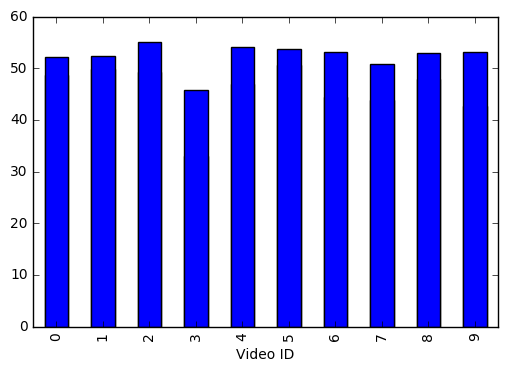

In [133]:
subjects = finaldata.groupby('subject ID').mean()
videos = finaldata.groupby('Video ID').mean()

videos['Attention'].plot(kind='bar')
videos['Meditation'].plot(kind='bar')
#videos['Raw'].plot(kind='bar')
#videos['Delta'].plot(kind='bar')
#videos['Theta'].plot(kind='bar')
#videos['Alpha 1'].plot(kind='bar')
#videos['Alpha 2'].plot(kind='bar')
#videos['Beta 1'].plot(kind='bar')
#videos['Beta 2'].plot(kind='bar')
#videos['Gamma1'].plot(kind='bar')
#videos['Gamma2'].plot(kind='bar')

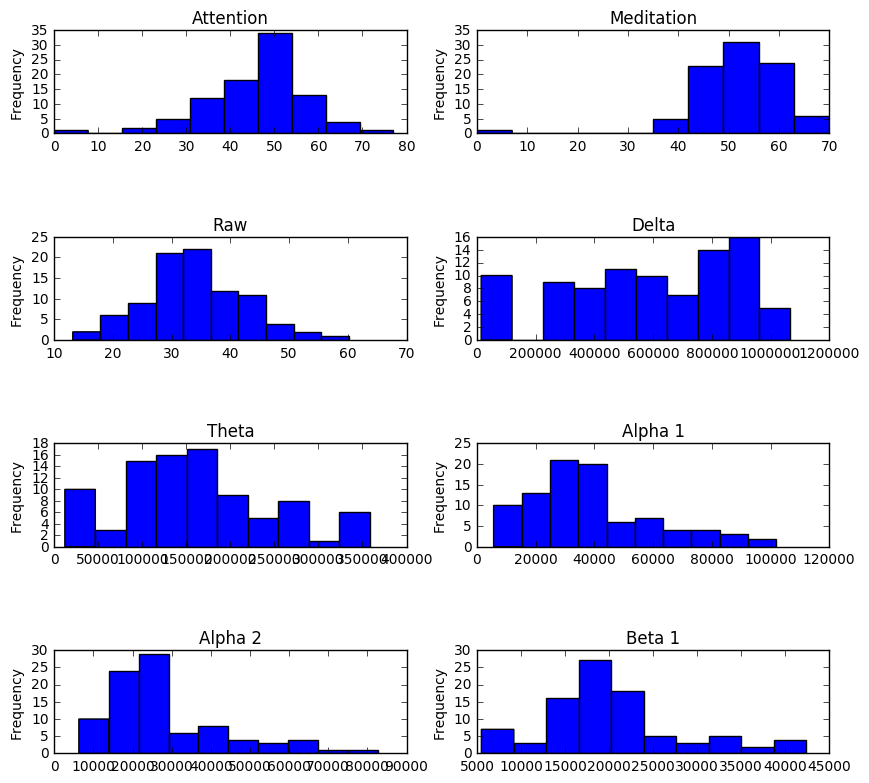

In [98]:
subvid = finaldata.groupby(['subject ID', 'Video ID']).mean()

numcols = ['Attention', 'Meditation', 'Raw', 'Delta', 'Theta', 'Alpha 1', 'Alpha 2', 'Beta 1', 'Beta 2', 'Gamma1', 'Gamma2']

fig = plt.figure(figsize = (10, 20))
fig.subplots_adjust(hspace=1.0)

plt.subplot(821)
subvid['Attention'].plot(kind = 'hist')
plt.title('Attention')

plt.subplot(822)
subvid['Meditation'].plot(kind = 'hist')
plt.title('Meditation')

plt.subplot(823)
subvid['Raw'].plot(kind = 'hist')
plt.title('Raw')

plt.subplot(824)
subvid['Delta'].plot(kind = 'hist')
plt.title('Delta')

plt.subplot(825)
subvid['Theta'].plot(kind = 'hist')
plt.title('Theta')

plt.subplot(826)
subvid['Alpha 1'].plot(kind = 'hist')
plt.title('Alpha 1')

plt.subplot(827)
subvid['Alpha 2'].plot(kind = 'hist')
plt.title('Alpha 2')

plt.subplot(828)
subvid['Beta 1'].plot(kind = 'hist')
plt.title('Beta 1')


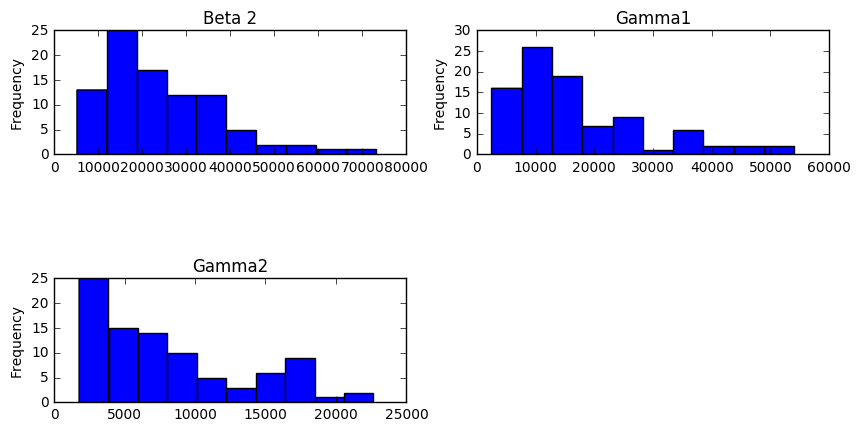

In [102]:
fig = plt.figure(figsize = (10, 8))
fig.subplots_adjust(hspace=1.0)

plt.subplot(321)
subvid['Beta 2'].plot(kind = 'hist')
plt.title('Beta 2')

plt.subplot(322)
subvid['Gamma1'].plot(kind = 'hist')
plt.title('Gamma1')

plt.subplot(323)
subvid['Gamma2'].plot(kind = 'hist')
plt.title('Gamma2')

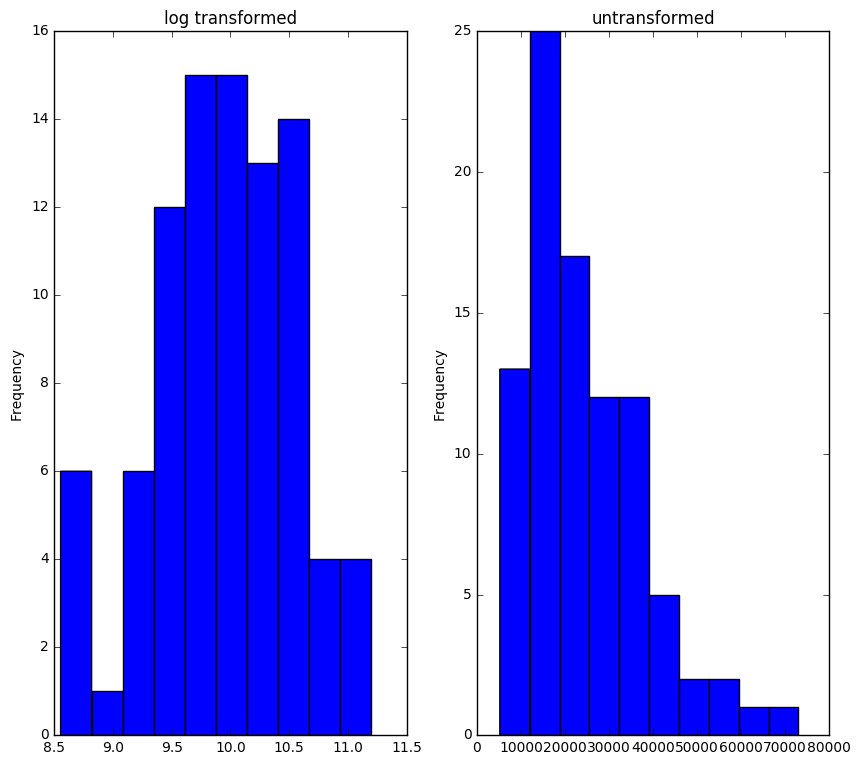

In [136]:
# create zscores for features that appear normally distributed:
scoredata = subvid[['Attention', 'Meditation', 'Raw']].apply(stats.zscore, axis=1)
scoredata.rename(columns={'Attention' : 'Attention_z', 'Mediation' : 'Meditation_z', 'Raw' : 'Raw_z'}, inplace=True)

# min max normalization for Delta variable (faily uniform)
minmaxdata = (subvid['Delta'] - subvid['Delta'].min()) / (subvid['Delta'].max() - subvid['Delta'].min())
minmaxdata = pd.DataFrame(minmaxdata)
minmaxdata.columns = ['Delta_mm']

# log transform on skewed columns
logdata = subvid[['Theta', 'Alpha 1', 'Alpha 2', 'Beta 1', 'Beta 2', 'Gamma1', 'Gamma2']].copy()
logdata.rename(columns = {'Theta' : 'Theta_log', 
                           'Alpha 1' : 'Alpha1_log', 
                           'Alpha 2' : 'Alpha2_log', 
                           'Beta 1' : 'Beta1_log', 
                           'Beta 2' : 'Beta2_log', 
                           'Gamma1' : 'Gamma1_log', 
                           'Gamma2' : 'Gamma2_log'}, 
                inplace = True)

logdata = logdata.apply(np.log, axis = 1)

nums_final = pd.concat([scoredata, minmaxdata, logdata], axis = 1)
nums_final.corr()


fig = plt.figure(figsize = (10, 20))

plt.subplot(221)
nums_final['Beta2_log'].plot(kind='hist')
plt.title('log transformed')

plt.subplot(222)
subvid['Beta 2'].plot(kind='hist')
plt.title('untransformed')


